# Text 1: Vector space models
**Internet Analytics - Lab 4**

---

**Group:** *Your group letter.*

**Names:**

* *Baffou Jérémy*
* *Basseto Antoine*
* *Pinto Andrea*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csr_matrix
from utils import load_json, load_pkl
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

courses = load_json('data/courses.txt')
stopwords = load_pkl('data/stopwords.pkl')

## Exercise 4.1: Pre-processing

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')

[nltk_data] Downloading package wordnet to /home/baffou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/baffou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /home/baffou/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

For me it makes sense to do filtering operations in this order:

- remove punctuation
- remove stop words
- remove digits
- lower case the words
- stemming
- lemming
- compute frequencies over all corpus
- remove too frequent and unfrequent terms 
- add n-grams (2 and 3 grams)

In [3]:
courses_rdd = sc.parallelize(courses)

In [4]:
# remove punctuations, stop words, digits and put every word to lower case
courses_processed = courses_rdd.map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : [word.casefold() for word in c["description"].translate(str.maketrans('', '', string.punctuation)).split() if (word.lower() not in stopwords and not word.isdigit())]})

### Lemming

In [5]:
tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
def tag_mapper(tag):
    if tag[0] in tag_dict:
        return tag_dict[tag[0]]
    else :
        return wordnet.NOUN

def lemmatize(words):
    return list(map(lambda w : lm.lemmatize(w[0],tag_mapper(w[1])),nltk.pos_tag(words)))

In [6]:
#lemmatization  (have to collect dataset because can't figure how to have wordnet downloaded on every workers)
lm = WordNetLemmatizer()
courses_lemmatized = sc.parallelize(list(map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : lemmatize(c["description"])},courses_processed.collect())))

### Stemming

In [7]:
ps = PorterStemmer()
courses_stemmed = courses_lemmatized.map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : list(map(lambda w : ps.stem(w), c["description"]))})

I'm not sure about stemming here. I mean it can cut words and group them into bigger group (worker, and working will be map to work which isn't done by the lemmatizer here). But sometimes it cuts too much end of words, so we lose a bit of meaning.

Now we're going to compute the frequencies of words in the **entire corpus**.

In [8]:
courses_word_aggregation = courses_stemmed.flatMap(lambda c : c["description"]) #flatten all words lists

In [9]:
words_number = courses_word_aggregation.count()
words_count = courses_word_aggregation.map(lambda w : (w,1)).reduceByKey(lambda w1,w2 : w1+w2).map(lambda w : (w[1],w[0])).sortByKey(False)
words_freq = words_count.map(lambda w : (w[1],w[0]/words_number))
words_freq_for_plot = np.asarray(words_freq.map(lambda w : w[1]).collect())

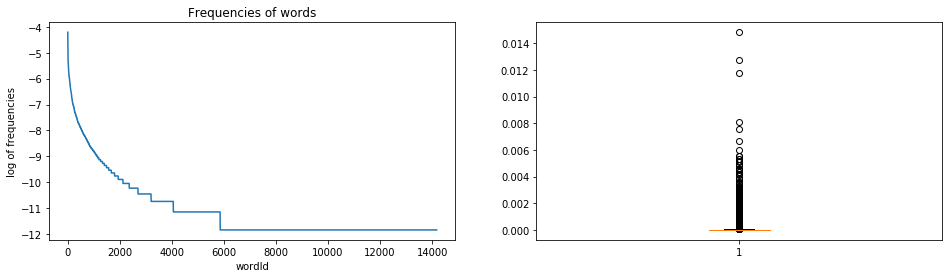

In [10]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
axs[0].set_title("Frequencies of words")
axs[0].set_xlabel("wordId")
axs[0].set_ylabel("log of frequencies")
plot1 = axs[0].plot(np.linspace(0,len(words_freq_for_plot), num=len(words_freq_for_plot)),np.log(words_freq_for_plot))
plot2 = axs[1].boxplot(words_freq_for_plot)

We want to erase words that are too frequent in the corpus as they are unlikely to differentiate documents. We choose to keep only the words which were under the 0.975 quantile because it corresponds more or less to the big vertical bar at the beginning in the frequencies plot.

In [11]:
really_frequent_indices = np.where(words_freq_for_plot > np.quantile(words_freq_for_plot,0.90)) # maybe change quantile
really_frequent_words = set(words_freq.take(really_frequent_indices[0][-1]))

Concerning the infrequent words we have:

In [12]:
single_apparition_words = words_count.filter(lambda w : w[0] == 1)
single_apparition_words.count()/words_count.count()

0.5870776610002116

So these words are a big part of the dataset, should we really cut them?

Now we cut the really frequent words in the list of words per course

In [13]:
bag_of_words_per_course = courses_stemmed.map(lambda c :{"courseId" : c["courseId"], "name" : c["name"], "description" : [w for w in c["description"] if w not in really_frequent_words]}) 

Prochaine fois que j ouvre faut lematiser, n-grams et potentiellement d'autre truc auquels je pense. Il faut faire gaffe parce que les freq faut les compute globalement mais les lemmatizes, stemming etc faut tout faire local parce qu'il faut garder la strucutre de mot par docs.

**As another process, we could make a list of words concerning administration : hour, project, student, ...**

### N-grams

A big question is at which step are we supposed to create the n-grams :
- before the first processing step
- after lemmatization
- after stemming 

I think that starting with after first lemming step is a good choice because we are interested of words in their context. And stemming is mainly here to extract most of the information of a single word but we lose information about the original one which, when associated with other, can give more information.

Another big question is how many n_grams do we create?

In [14]:
two_grams = courses_lemmatized.map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : [w for w in ngrams(c["description"],2)]})
three_grams = courses_lemmatized.map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : [w for w in ngrams(c["description"],3)]})
four_grams =courses_lemmatized.map(lambda c : {"courseId" : c["courseId"], "name" : c["name"], "description" : [w for w in ngrams(c["description"],4)]})
n_grams = two_grams.union(three_grams.union(four_grams))

---

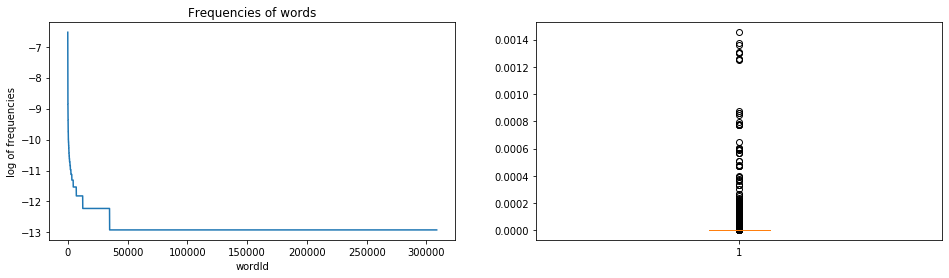

In [17]:
n_gram_aggregation = n_grams.flatMap(lambda c : c["description"]) #flatten all words lists
n_gram_number = n_gram_aggregation.count()
n_gram_count = n_gram_aggregation.map(lambda w : (w,1)).reduceByKey(lambda w1,w2 : w1+w2).map(lambda w : (w[1],w[0])).sortByKey(False)
n_gram_freq = n_gram_count.map(lambda w : (w[1],w[0]/n_gram_number))
n_gram_freq_for_plot = np.asarray(n_gram_freq.map(lambda w : w[1]).collect())
fig,axs = plt.subplots(1,2,figsize=(16,4))
axs[0].set_title("Frequencies of words")
axs[0].set_xlabel("wordId")
axs[0].set_ylabel("log of frequencies")
plot1 = axs[0].plot(np.linspace(0,len(n_gram_freq_for_plot), num=len(n_gram_freq_for_plot)),np.log(n_gram_freq_for_plot))
plot2 = axs[1].boxplot(n_gram_freq_for_plot)

In [18]:
really_frequent_n_gram_indices = np.where(n_gram_freq_for_plot > np.quantile(n_gram_freq_for_plot,0.90)) # maybe change quantile
really_frequent_n_gram = set(n_gram_freq.take(really_frequent_n_gram_indices[0][-1]))

In [20]:
really_frequent_n_gram

{(('passfail', 'basis', 'supervise'), 9.803104643240514e-06),
 (('web', 'page'), 7.3523284824303856e-06),
 (('base', 'specification', 'cp4choose'), 7.3523284824303856e-06),
 (('algorithm', 'teach'), 9.803104643240514e-06),
 (('laboratory', 'laboratories', 'approve', 'smx'), 7.3523284824303856e-06),
 (('learn', 'outcomes', 'end', 'student'), 0.00013479268884455706),
 (('write', 'report', 'assessment', 'method'), 1.4704656964860771e-05),
 (('signal', 'processing', 'tool'), 9.803104643240514e-06),
 (('functional', 'data'), 7.3523284824303856e-06),
 (('system', 'learn', 'outcomes', 'end'), 4.166319473377219e-05),
 (('plan', 'ongoing', 'learn', 'goalsuse'), 7.3523284824303856e-06),
 (('presentation', 'class'), 7.3523284824303856e-06),
 (('teach', 'method', 'lecture', 'presentation'), 7.3523284824303856e-06),
 (('learning', 'goal', 'teach', 'method'), 4.166319473377219e-05),
 (('concept', 'start', 'linear'), 2.205698544729116e-05),
 (('digital', 'signal', 'processing'), 1.4704656964860771e-0

Sould we cut off the n-grams that are too frequent?

### Bag of words creation

We will use the bag of words per course, put them in sets and make union so that we don't keep duplicate. Then we will do the same things for n-grams, and finally union them all. 

In [15]:
bag_of_words = bag_of_words_per_course.map(lambda c : set(c["description"])).reduce(lambda s1,s2 : s1.union(s2))
bag_of_words = bag_of_words.union(n_grams.map(lambda c : set(c["description"])).reduce(lambda s1,s2 : s1.union(s2)))

### IX description

Should the n_grams be included?

In [27]:
sorted(bag_of_words_per_course.filter(lambda c : c["courseId"] == "COM-308").take(1)[0]["description"])

['acquir',
 'activ',
 'ad',
 'ad',
 'advertis',
 'algebra',
 'algebra',
 'algorithm',
 'algorithm',
 'analysi',
 'analyt',
 'analyt',
 'apach',
 'applic',
 'applic',
 'assess',
 'auction',
 'auction',
 'balanc',
 'base',
 'base',
 'basic',
 'basic',
 'basic',
 'cathedra',
 'chain',
 'class',
 'class',
 'class',
 'cloud',
 'cluster',
 'cluster',
 'collect',
 'com300',
 'combin',
 'commun',
 'commun',
 'commun',
 'comput',
 'comput',
 'concept',
 'concept',
 'concret',
 'content',
 'cours',
 'cours',
 'coverag',
 'curat',
 'current',
 'data',
 'data',
 'data',
 'data',
 'data',
 'data',
 'dataset',
 'dataset',
 'decad',
 'dedic',
 'design',
 'detect',
 'detect',
 'dimension',
 'draw',
 'ecommerc',
 'ecommerc',
 'effect',
 'effici',
 'end',
 'exam',
 'expect',
 'explor',
 'explor',
 'explor',
 'explor',
 'explor',
 'field',
 'final',
 'foundat',
 'framework',
 'function',
 'fundament',
 'good',
 'graph',
 'graph',
 'hadoop',
 'hadoop',
 'handson',
 'homework',
 'homework',
 'import',
 'in

## Exercise 4.2: Term-document matrix

## Exercise 4.3: Document similarity search